<a href="https://colab.research.google.com/github/Kat-nesh/Redefining-maize-UAI/blob/main/Model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites

- Import earth engine and geemap



In [2]:
from IPython.core.magics.execution import Restart
try:
  import geemap
  import ee
  import geopandas
except Exception as e:
  !pip install geopandas
  !pip install geemap
  Restart()
finally:
  import geemap
  import ee

In [ ]:
#geemap.update_package()

In [3]:
try:
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize(project='ee-maizeyield')

In [5]:
# import sys
# path_to_module = '/content/drive/MyDrive/Functions'
# sys.path.append(path_to_module)
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from geemap import ml
from sklearn import ensemble
from geemap import ml
from sklearn import ensemble
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
plt.rcParams.update({'figure.figsize': (12.0,8.0)})
plt.rcParams.update({'font.size' : 14})
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# 1.Predictor Variables Preprocessing

Steps include:
1. Exploratory investigations
2. Data cleaning  (removing NAs)

In [6]:
# Loading training data
df = pd.read_csv('/content/drive/MyDrive/All_Predictors/reprocessed-indices_with_FinalJoined.csv')
df.describe(include='all')


,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
count,543,543,543.000000,378.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,...,543.000000,543.000000,543.000000,543.000000,543.000000,418.000000,543.000000,461.000000,459.000000,543.000000
unique,543,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022_WEST POKOT,BARINGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2015.972376,1.565389,15315.570308,15989.082517,16274.957286,21294.584040,18042.908219,14592.711695,...,140.392954,81.130388,97.503739,18.849126,9925.435195,1.546818,15055.470270,2.121945,1.492754,1.518524
std,NaN,NaN,3.736374,0.935836,5154.868047,4523.001854,4851.937539,2438.465086,2536.106998,1724.637864,...,111.594427,68.597981,85.209268,15.670354,15808.970276,0.943439,200.684338,1.175216,0.931341,0.934726
min,NaN,NaN,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.005076,0.005076
25%,NaN,NaN,2013.000000,0.897919,11578.464515,12675.343325,12820.878185,19524.226175,16162.782465,13246.450865,...,35.099998,28.900000,8.862897,7.049760,489.049999,0.880000,14921.106945,1.364666,0.841769,0.864907
50%,NaN,NaN,2016.000000,1.368918,14092.756490,14843.976210,15048.983630,20923.751730,17376.882110,14282.928530,...,139.899994,66.800003,88.027273,15.812626,5830.299988,1.335000,15028.829250,2.199110,1.287565,1.316058
75%,NaN,NaN,2019.000000,2.156738,17638.990315,18022.087680,18455.477785,22862.531525,19527.345580,15960.990505,...,211.250000,118.699997,157.332478,26.534196,14176.408300,2.075000,15156.443275,2.957867,1.933931,2.013530


In [7]:
df.columns

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld'],
      dtype='object')

In [8]:
data = df[df['Year'].between(2010, 2020)]

1.1. Data cleaning (removing NAs and unneded columns)

In [9]:
# FIND & REMOVE NAs
data.isna().sum()
data[data.isna().any(axis=1)]


,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
0,2010_BARINGO,BARINGO,2010,2.446140,13466.61207,13579.56526,14037.68821,18064.05894,16139.75614,12884.67164,...,223.633331,124.183334,165.862906,26.893221,27201.516640,NaN,14969.65208,1.202656,NaN,2.446140
1,2010_BOMET,BOMET,2010,2.534296,9273.87625,10270.83435,10170.83956,18802.30141,15480.64139,11918.84365,...,202.533325,100.216660,133.915805,20.536819,7767.116714,NaN,14964.35159,4.933519,NaN,2.534296
2,2010_BUNGOMA,BUNGOMA,2010,2.616617,17854.93803,17050.62684,17695.21449,20411.25788,17761.26924,13750.84017,...,196.516663,49.683334,168.121518,12.796983,22528.283370,NaN,14963.83447,3.188185,NaN,2.616617
3,2010_BUSIA,BUSIA,2010,3.114873,20577.71760,19430.25052,20177.74615,21080.29136,19366.22202,14691.73165,...,199.400009,71.033340,168.821512,15.097006,14518.650010,NaN,15079.52976,3.514851,NaN,3.114873
4,2010_ELGEYO-MARAKWET,ELGEYO-MARAKWET,2010,3.114873,17064.11439,16820.43171,17288.38226,20857.02672,18154.90550,13714.83444,...,231.000000,91.683334,185.939693,19.557142,14131.416660,NaN,14751.63249,0.773917,NaN,3.114873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2020_TRANS NZOIA,TRANS NZOIA,2020,NaN,11423.19365,12580.21582,12403.76220,20073.05458,15411.51212,12704.22565,...,251.399994,133.199997,152.804425,26.381924,17266.900030,4.60,14901.72507,3.111544,4.599809,4.599809
457,2020_TURKANA,TURKANA,2020,NaN,10528.29216,11956.59972,12158.56849,18751.22224,15154.14727,12805.21778,...,110.900002,0.000000,110.900002,0.000000,110.900002,1.04,15700.95508,0.060408,1.043332,1.043332
458,2020_UASIN GISHU,UASIN GISHU,2020,NaN,14500.63058,15450.36500,15352.61890,21801.69814,17019.21576,14283.80663,...,250.300003,131.300003,153.013415,21.984603,25094.199980,3.07,14842.86930,3.088151,3.065103,3.065103
459,2020_VIHIGA,VIHIGA,2020,NaN,10248.27979,11497.61877,11341.02221,19327.11004,15125.41108,12277.52069,...,396.200012,86.600006,342.144827,17.528276,9922.199982,1.36,14952.29812,2.612361,1.359433,1.359433


In [10]:
train = data.drop(columns = ['AREA','key','RANGE','COUNTY'])
train.describe()

,Year,Yield,blue,green,red,nir,swir1,swir2,ndvi,savi,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
count,461.000000,378.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,...,461.000000,461.000000,461.000000,461.000000,461.000000,377.000000,461.000000,461.000000,377.000000,461.000000
mean,2014.989154,1.565389,15413.454259,16035.975727,16347.604134,21227.513130,18042.259340,14523.145163,0.152170,0.228252,...,144.131180,83.067897,100.195398,19.315664,10289.432996,1.571220,15053.640804,2.121945,1.536283,1.558705
std,3.160540,0.935836,5396.852876,4722.485294,5078.652003,2472.150062,2630.079343,1723.876089,0.093239,0.139857,...,113.963405,69.935337,86.706050,15.901291,16675.709297,0.937679,200.463762,1.175216,0.932666,0.935326
min,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,-0.125322,-0.187981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.071642,0.071642
25%,2012.000000,0.897919,11440.506530,12569.025170,12726.295270,19374.466470,16126.576420,13175.964870,0.104337,0.156503,...,38.000000,33.299999,11.487143,7.569266,758.600007,0.900000,14921.335210,1.364666,0.886684,0.901980
50%,2015.000000,1.368918,14064.890690,14811.063700,14930.986940,20783.808090,17314.475710,14191.067040,0.168225,0.252335,...,138.600006,66.599998,87.055883,15.909070,5918.016678,1.380000,15028.829250,2.199110,1.311205,1.337808
75%,2018.000000,2.156738,17864.987290,18125.811950,18580.042740,22883.315890,19505.411060,15853.188390,0.219557,0.329329,...,214.800003,121.200005,158.198156,26.893221,14614.299990,2.110000,15150.634030,2.957867,2.014130,2.078988
max,2020.000000,5.090926,40761.130780,39770.558290,40505.574260,32026.710420,32362.643070,18865.725980,0.310899,0.466341,...,600.500000,443.000000,389.870093,93.047153,264718.399900,5.090000,15878.890780,5.522266,5.224867,5.224867


1.2. Exploratory investigations (statistics)

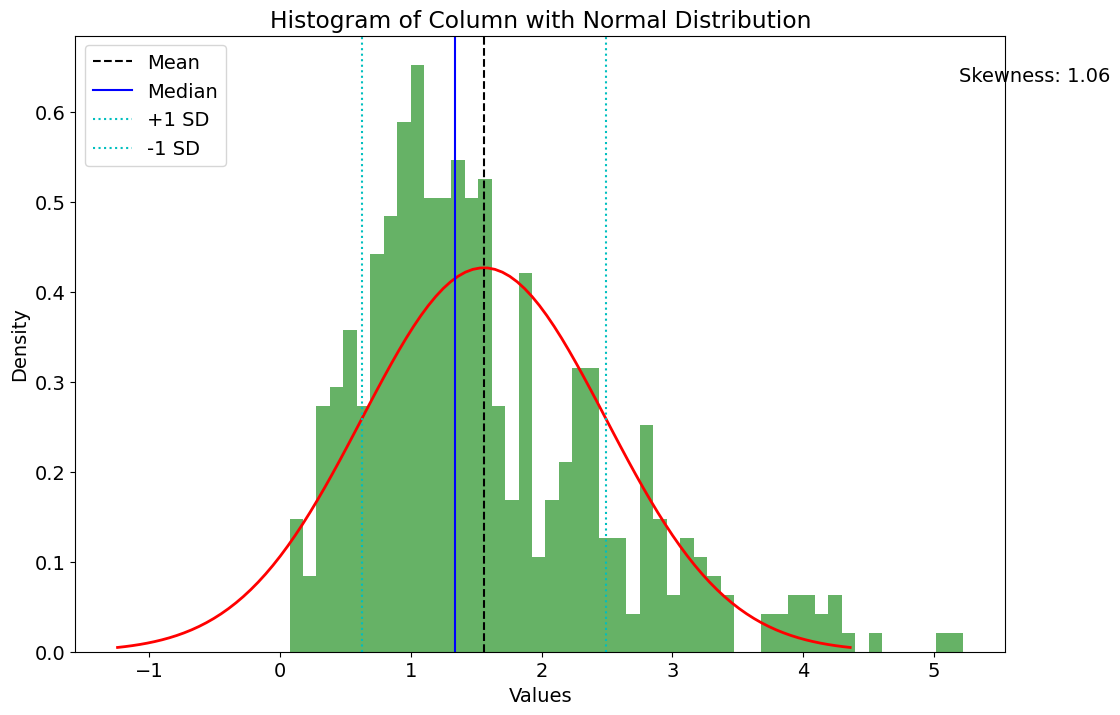

In [11]:
# Investigate Yield Data
column = data['JoinedYld']

# Calculate the mean, median, and standard deviation
mean = column.mean()
median = column.median()
std = column.std()

# Calculate the skewness
skewness = column.skew()

# Fit a normal distribution to the data
mu, std_fit = stats.norm.fit(column)

# Plot the histogram
n, bins, patches = plt.hist(column, bins=50, density=True, alpha=0.6, color='g')

# Plot the normal distribution
x = np.linspace(mu - 3*std_fit, mu + 3*std_fit, 100)
y = stats.norm.pdf(x, mu, std_fit)
plt.plot(x, y, 'r', linewidth=2)

# Add mean, median, and standard deviation lines
plt.axvline(mean, color='k', linestyle='--', label='Mean')
plt.axvline(median, color='b', linestyle='-', label='Median')
plt.axvline(mean + std, color='c', linestyle=':', label='+1 SD')
plt.axvline(mean - std, color='c', linestyle=':', label='-1 SD')

# Add a title and labels to the x and y axes
plt.title('Histogram of Column with Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Density')

# Add skewness text
plt.text(0.95, 0.95, 'Skewness: {:.2f}'.format(skewness),
         horizontalalignment='left',
         verticalalignment='top',
         transform=plt.gca().transAxes)

# # Add a legend
plt.legend()

# Show the plot
plt.show()



Train and Test Splits on the dataset

In [12]:
features = train
features.columns, features.shape

(Index(['Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
        'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
        'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
        'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
        'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
        'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
        'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
        'temp_MAX', 'temp_MEAN', 'temp_STD', 'temp_SUM', 'fpar', 'm_lai',
        'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp', 'Tmst_AREA', 'Tmst_MIN',
        'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN', 'Tmst_STD', 'Tmst_SUM', 'Yield2',
        'mod_lst', 'ggcp10', 'final_Yld', 'JoinedYld'],
       dtype='object'),
 (461, 70))

In [13]:
# TRAIN SPLIT
yld = train['JoinedYld']
yld.shape
pred = train.drop([ 'Year', 'Yield', 'blue', 'green', 'red', 'nir', 'swir1','swir2','Tmst_STD', 'Tmst_SUM', 'Yield2', 'ggcp10', 'final_Yld','Tmst_RANGE',
                         'Tmst_AREA','temp_STD','temp_SUM', 'JoinedYld'], axis=1)
# y_train

In [14]:
pred.columns

Index(['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
       'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
       'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
       'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
       'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
       'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
       'temp_MAX', 'temp_MEAN', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi',
       'gpp', 'npp', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_MEAN', 'mod_lst'],
      dtype='object')

In [15]:
pred.shape,yld.shape

((461, 52), (461,))

In [ ]:
# y_train = train['Yield']
# x_train = features.drop(['Yield','county','code','evi', 'gci', 'gli',], axis=1)
# # x_train,y_train# sipi, savi, nsi, ndvi, ndmi,msavi, gndvi

In [16]:
features = pred


In [17]:
train['JoinedYld'].count()

np.int64(461)

# 2.Model Training
1. Feature Selection
2. Model Training
3. Model Testing (Leave One Year Out Cross Validation)
4. Model Evaluation

In [18]:
# RF Regressor & Fit
# create a classifier and fit
n_trees = 200
clf = RandomForestRegressor(n_trees,random_state = 42)
clf.fit(pred,yld)

RandomForestRegressor(n_estimators=200, random_state=42)

In [19]:
feature_name=pred.columns

In [20]:
feature_name

Index(['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi', 'msavi', 'gci', 'gli',
       'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2', 'rdvi', 'gvi', 'ndii',
       'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi', 'pssra', 'dvi',
       'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec', 'era5_mean_temp',
       'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp', 'era5m_min_temp',
       'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec', 'temp_MIN',
       'temp_MAX', 'temp_MEAN', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi',
       'gpp', 'npp', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_MEAN', 'mod_lst'],
      dtype='object')



# 3.Feature Selection based on Feature Importance

In [21]:
# Feature Selection
# Feature Importance
clf.feature_importances_

array([0.00095541, 0.00089115, 0.00865428, 0.00113079, 0.0065009 ,
       0.00979437, 0.0009537 , 0.00211833, 0.0058811 , 0.00866527,
       0.00166057, 0.00086255, 0.00233454, 0.0020705 , 0.00124599,
       0.00150363, 0.01010613, 0.0068464 , 0.00317547, 0.00817847,
       0.0006608 , 0.00239754, 0.00492636, 0.01804289, 0.0026042 ,
       0.0020536 , 0.39653548, 0.01428357, 0.0137599 , 0.04657113,
       0.01445207, 0.03710307, 0.03680408, 0.01055427, 0.01986988,
       0.01109583, 0.01115693, 0.0132585 , 0.01750101, 0.10285387,
       0.01919159, 0.00536607, 0.00579438, 0.00475122, 0.00564035,
       0.01184182, 0.01519328, 0.02063573, 0.00451078, 0.02219626,
       0.00988108, 0.01498291])

In [22]:
clf.n_features_in_

52

In [23]:
feature_importance = pd.DataFrame(clf.feature_importances_,columns =['Importance'])
feature_importance['Features'] = clf.feature_names_in_
feature_importance.sort_values(by=['Importance'], ascending=False)

,Importance,Features
26,0.396535,era5d_prec
39,0.102854,temp_MAX
29,0.046571,era5m_prec
31,0.037103,era5_min_temp
32,0.036804,era5_max_temp
49,0.022196,Tmst_MAX
47,0.020636,npp
34,0.019870,era5m_min_temp
40,0.019192,temp_MEAN
23,0.018043,wdvi


In [24]:
sorted_idx = clf.feature_importances_.argsort()
sorted_idx.shape

(52,)

In [25]:
# features = data.columns[:13]
features = pred.columns
features.shape

(52,)

Text(0.5, 1.0, 'Predictors Correlation')

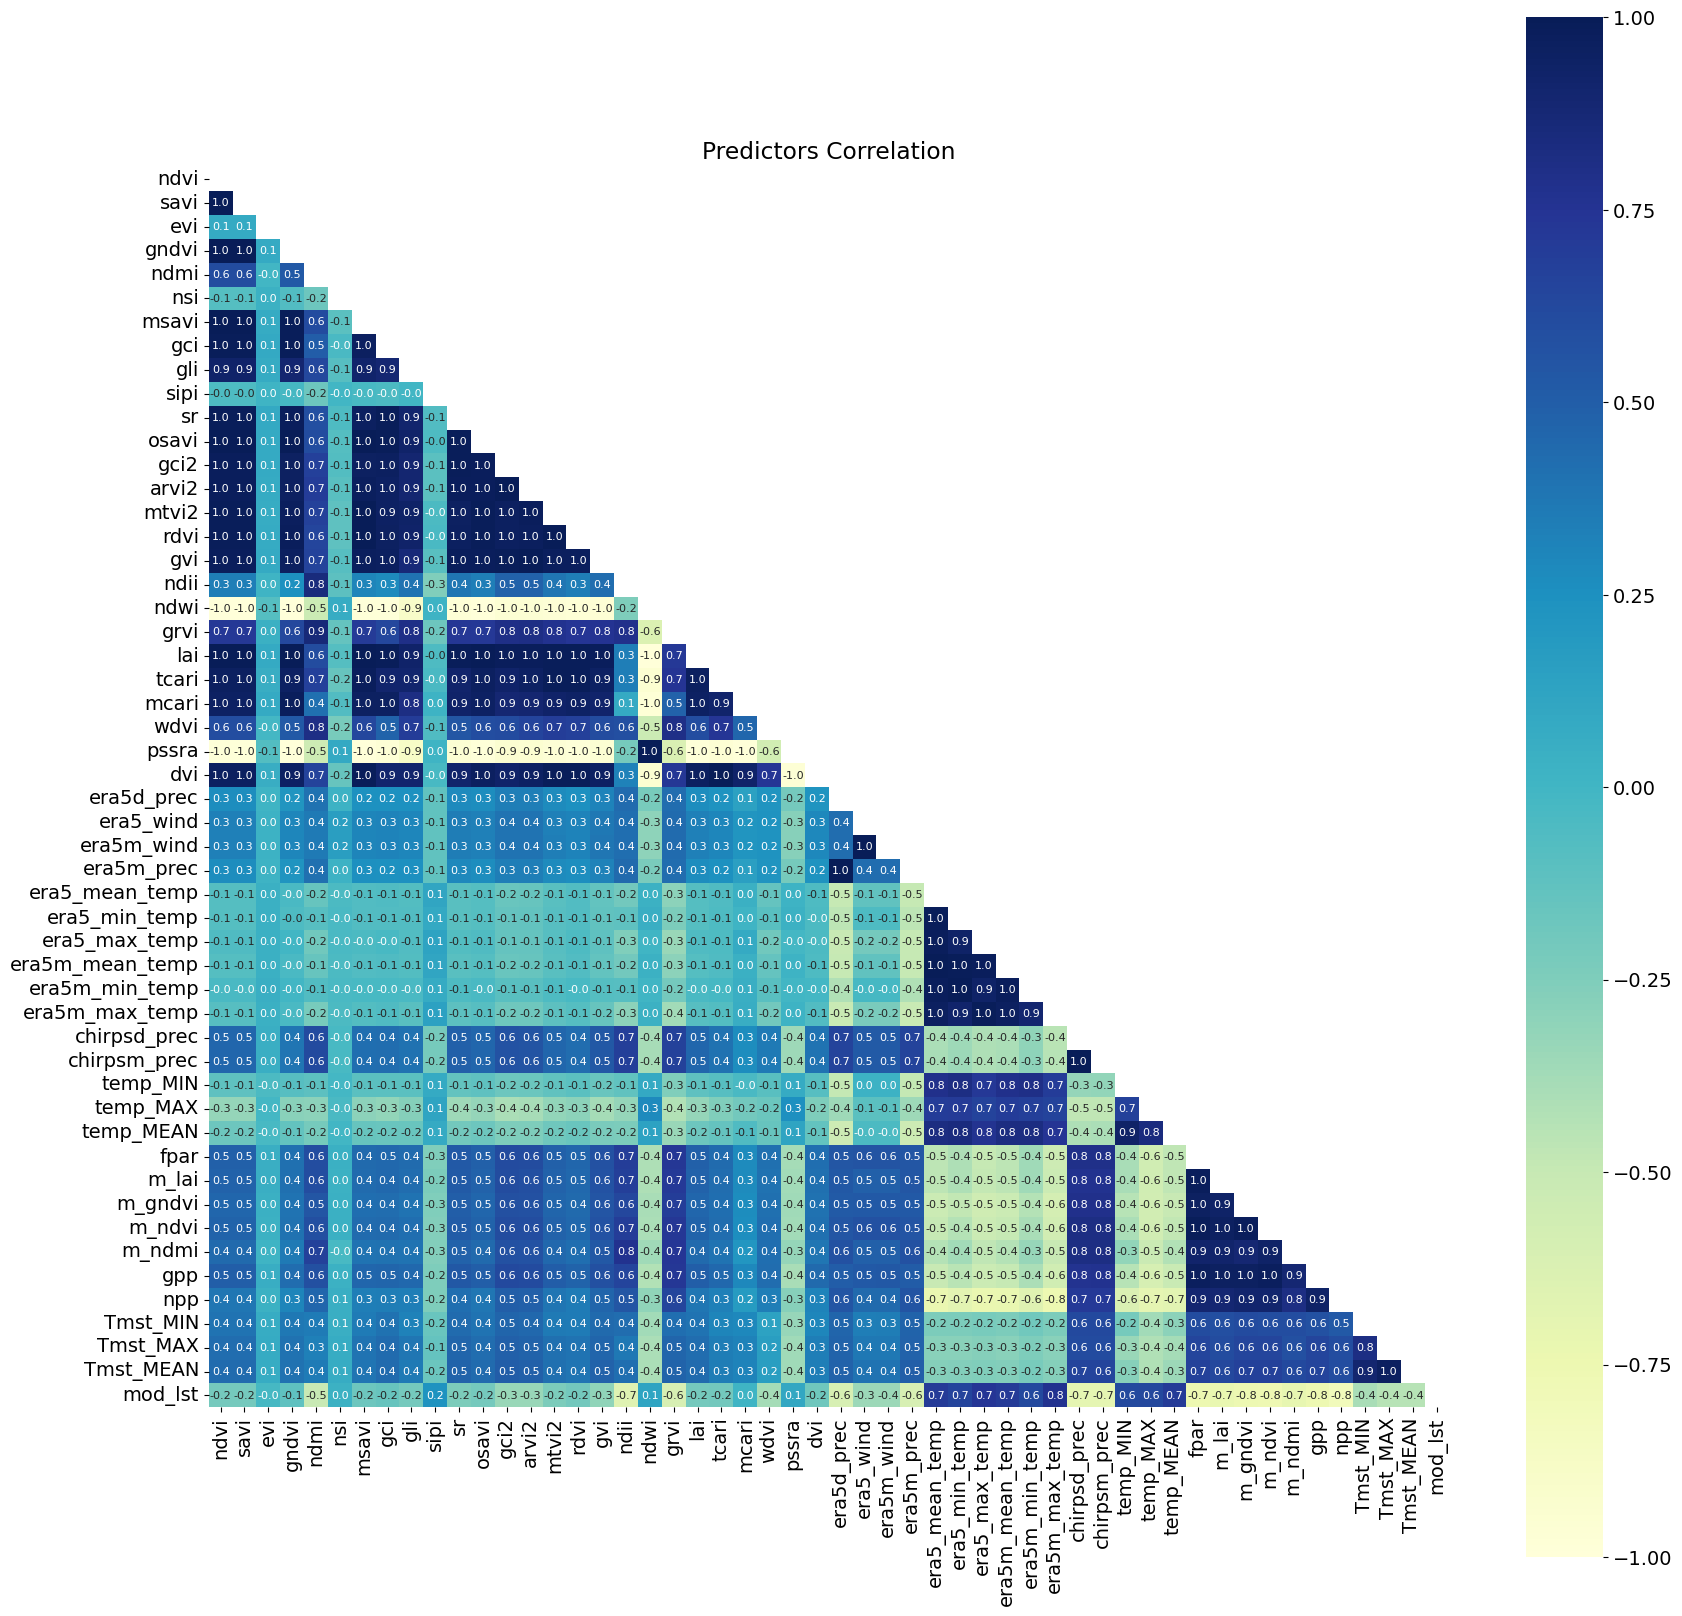

In [26]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

pred_corr = pred.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(pred_corr, dtype=bool))

# Plot heatmap
sns.heatmap(pred_corr, cmap="YlGnBu", annot=True, fmt=".1f", ax=ax,annot_kws={"fontsize": 8},mask=mask, square=True)
ax.set_title("Predictors Correlation")


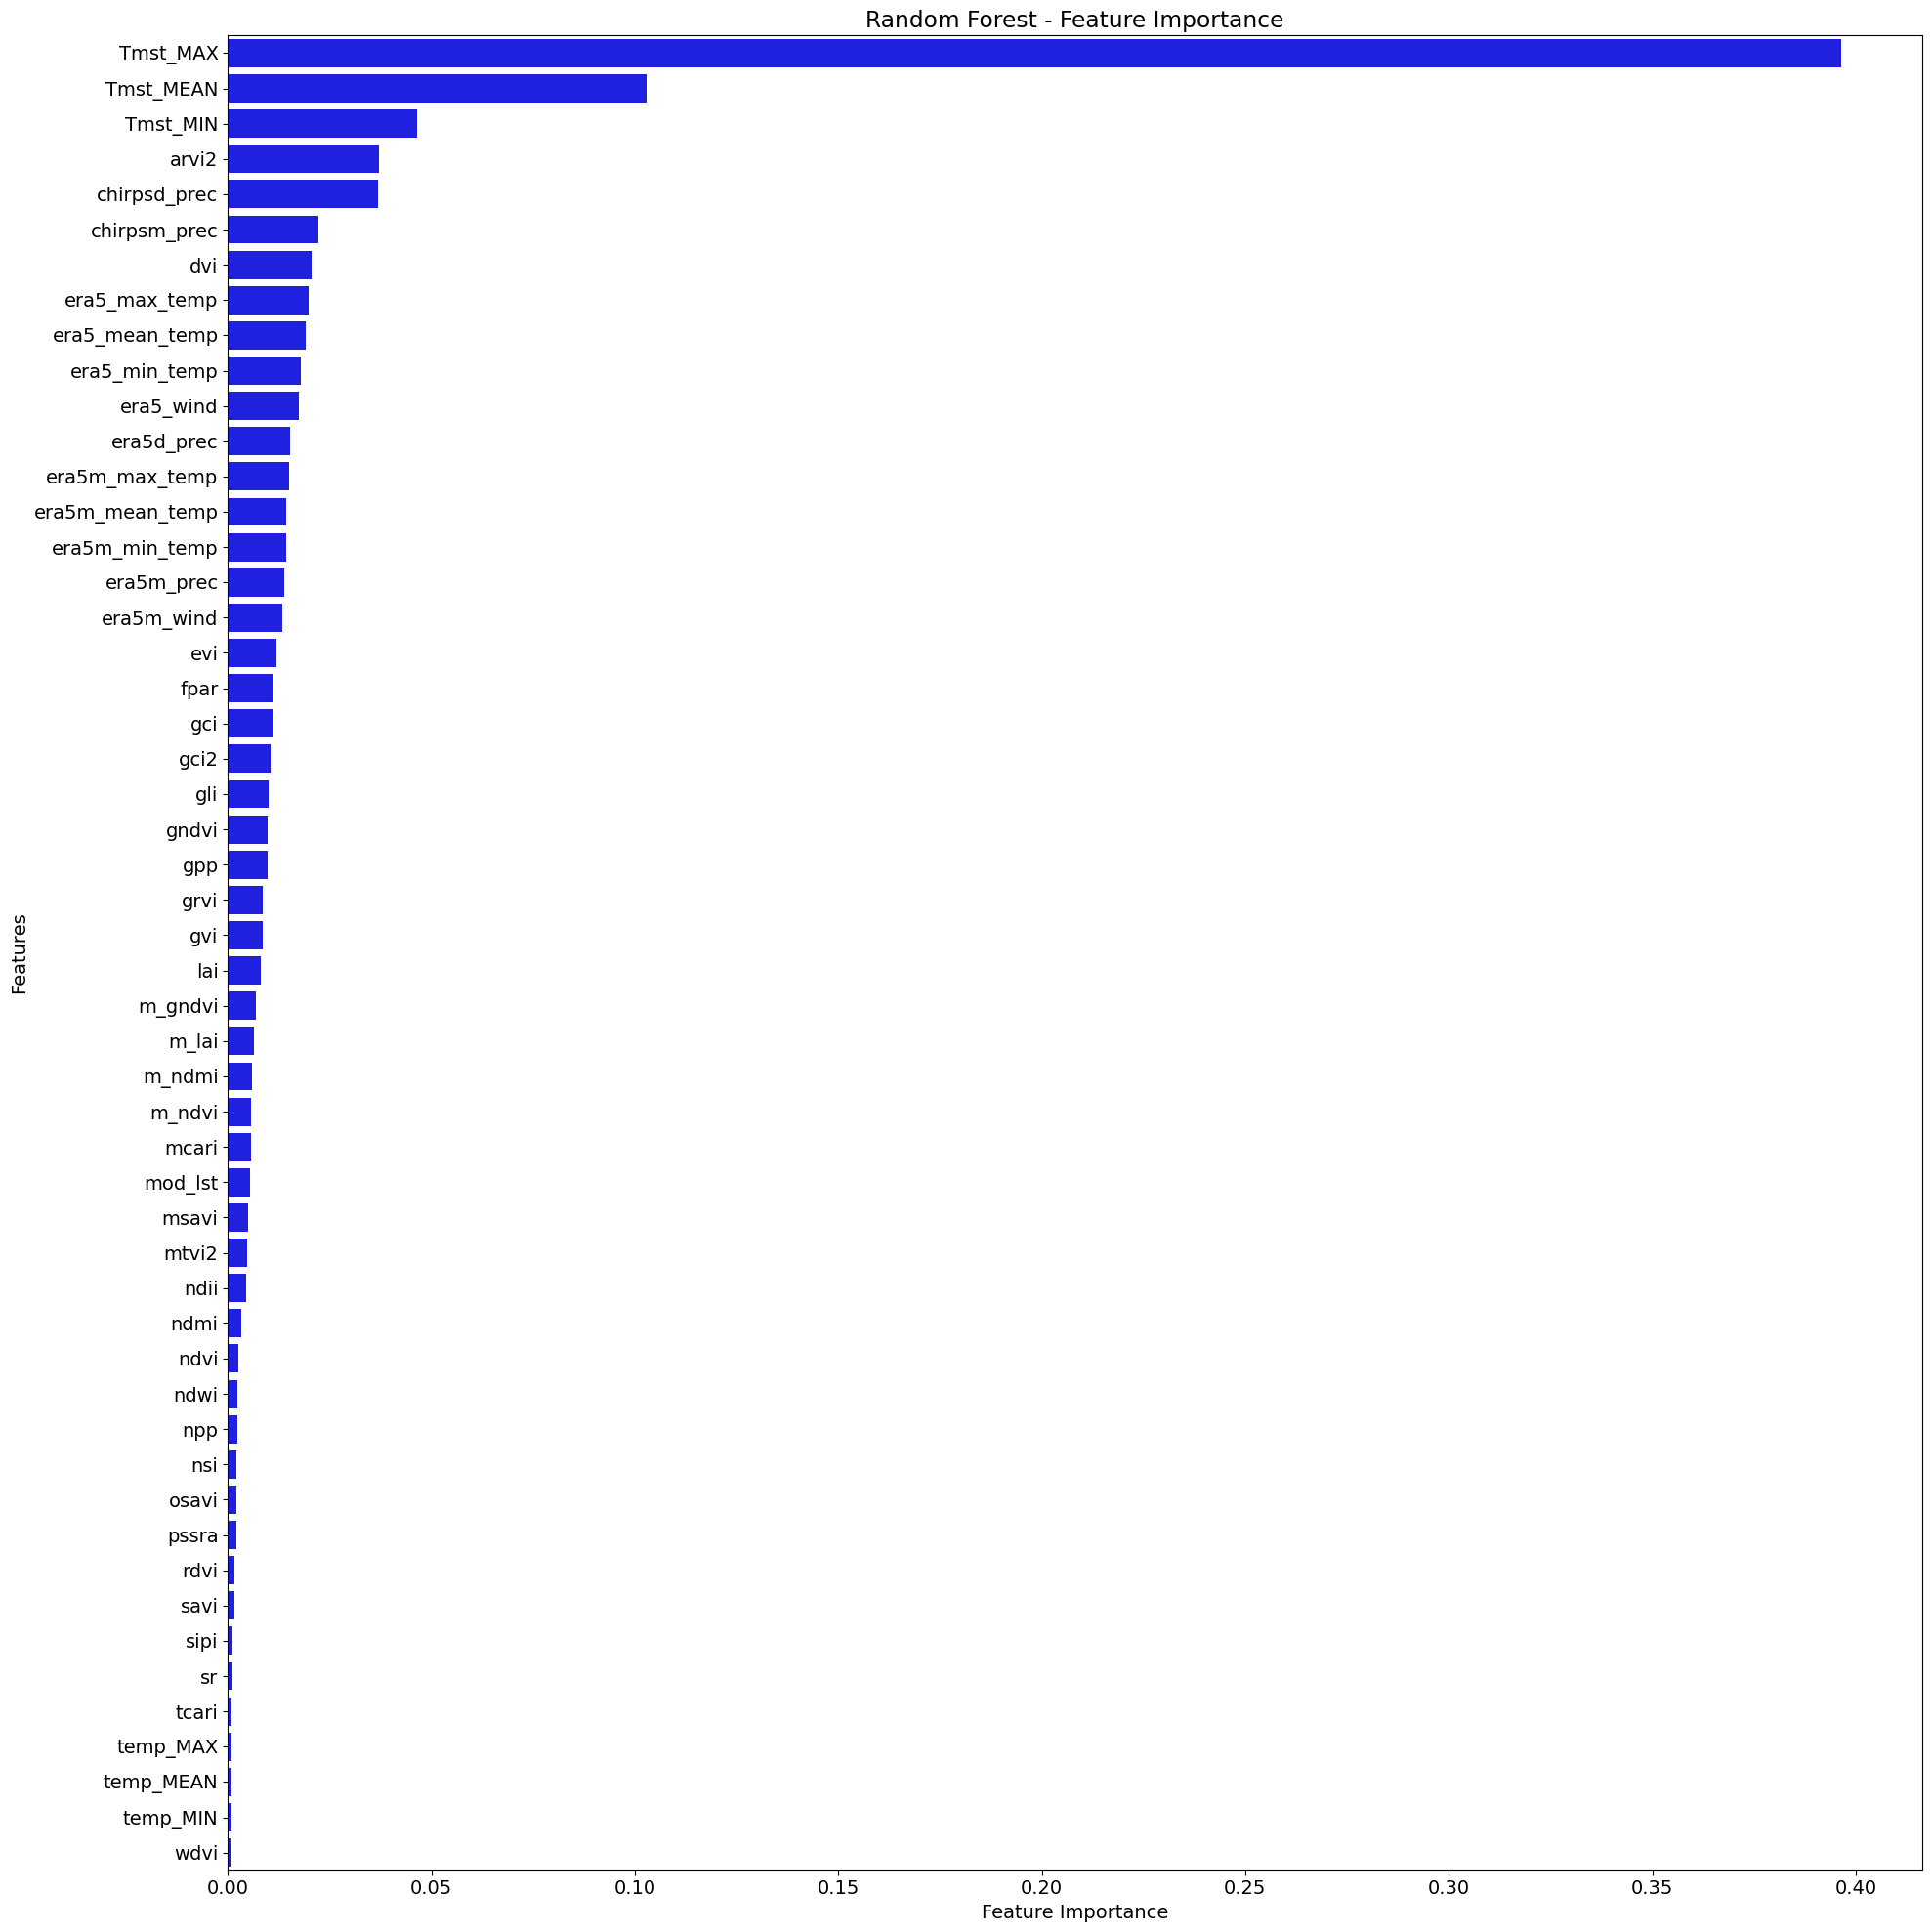

In [28]:
# Plot horizontal bar plot
fig, ax = plt.subplots(figsize=(20, 20))
totals = feature_importance.groupby('Features')["Importance"].mean().sort_values(ascending=False)
sns.barplot(y=totals.index.sort_values(ascending=True), x=totals.values, color="blue", ax=ax,orient='h',)
ax.set_title("Random Forest - Feature Importance")
ax.set_xlabel("Feature Importance")

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

In [29]:
sns.set(font_scale=0.75)

**Permutation Based Importance**

Randomly shuffles each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important ones

**Pros:**
- overcome drawbacks of default feature importance computed with mean impurity decrease (**Gini importance**)

**Cons:**
- can have problem with highly-correlated features

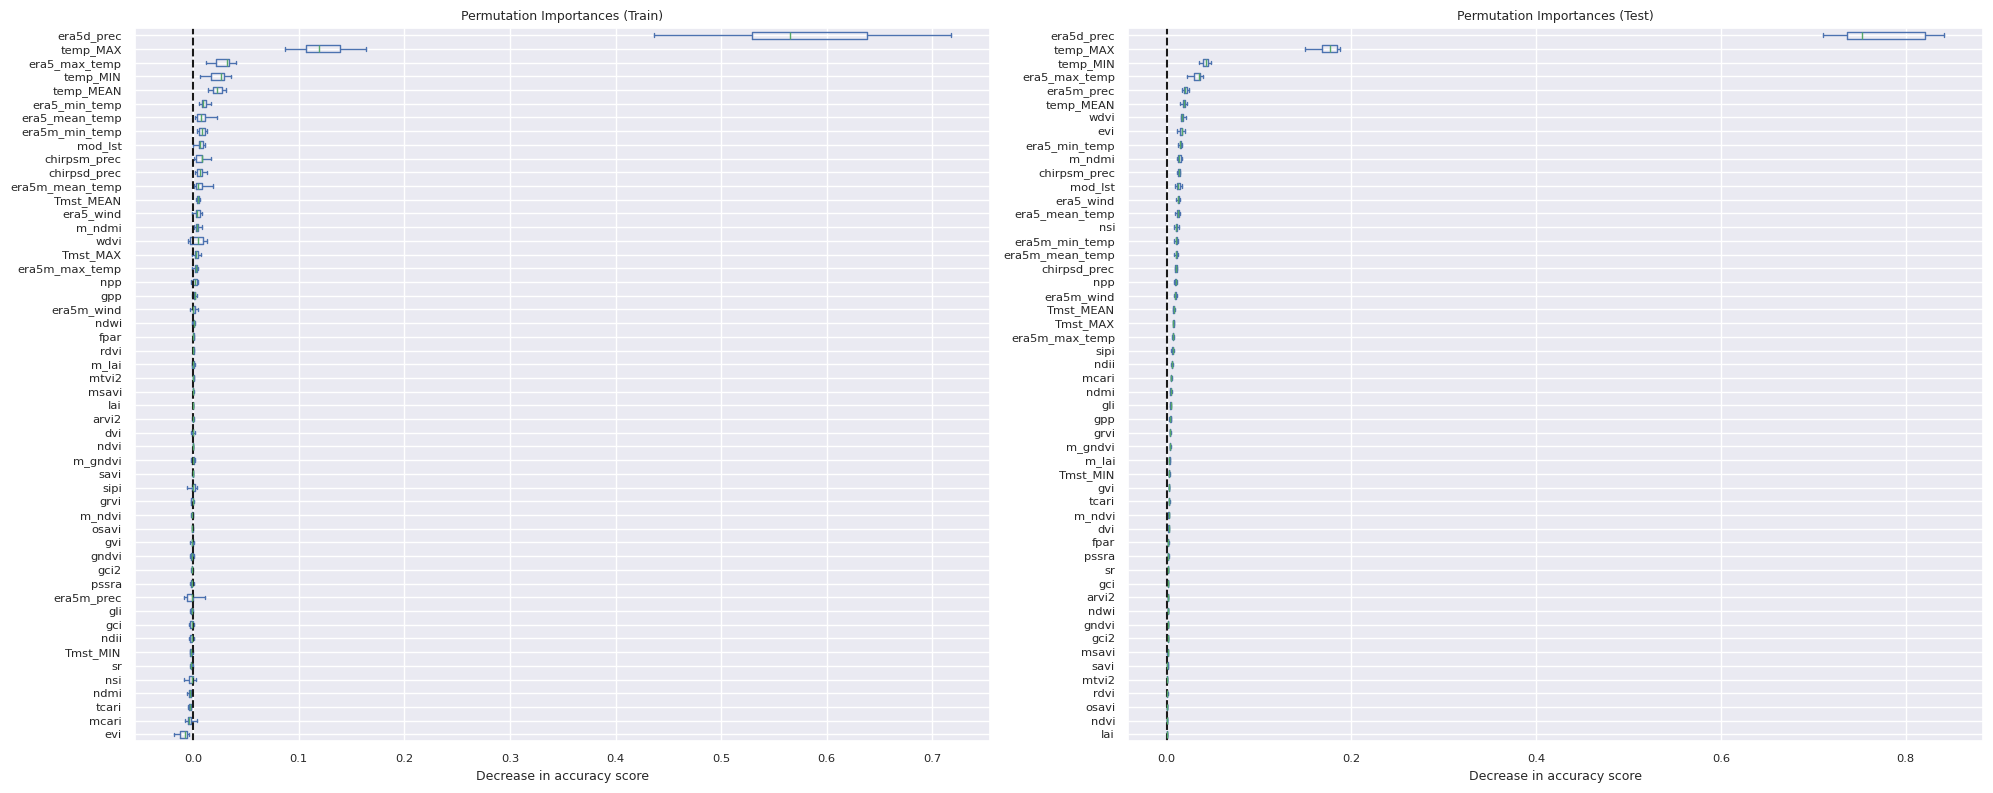

In [30]:
#  Plotting Permutation Importance on train and test data can give a hint if there is an overfitting.
# Features that are likely to be useful and lead to overfitting will have a higher Permutation Importance weight on train data
#  and a lower or almost zero weight on test data.
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

clf = RandomForestRegressor(200,random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(pred,yld, test_size = 0.6, random_state=1)
main_pipeline = clf.fit(X_test,y_test)

pi_train = permutation_importance(
    main_pipeline,
    X_train, y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_importances_idx = pi_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    pi_train.importances[sorted_importances_idx].T,
    columns=pred.columns[sorted_importances_idx],
)


pi_test = permutation_importance(
    main_pipeline,
    X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

sorted_importances_idx = pi_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    pi_test.importances[sorted_importances_idx].T,
    columns=pred.columns[sorted_importances_idx],
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1 = importances_train.plot.box(vert=False, whis=10, ax=ax1)
ax1.set_title("Permutation Importances (Train)")
ax1.axvline(x=0, color="k", linestyle="--")
ax1.set_xlabel("Decrease in accuracy score")
ax1.figure.tight_layout()

ax2 = importances_test.plot.box(vert=False, whis=10, ax=ax2)
ax2.set_title("Permutation Importances (Test)")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

**Feature Importance Computed with SHAP Values**

(it is model-agnostic) to compute the feature importances from the Random Forest. It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction.



In [32]:
!pip install shap

In [33]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(pred)

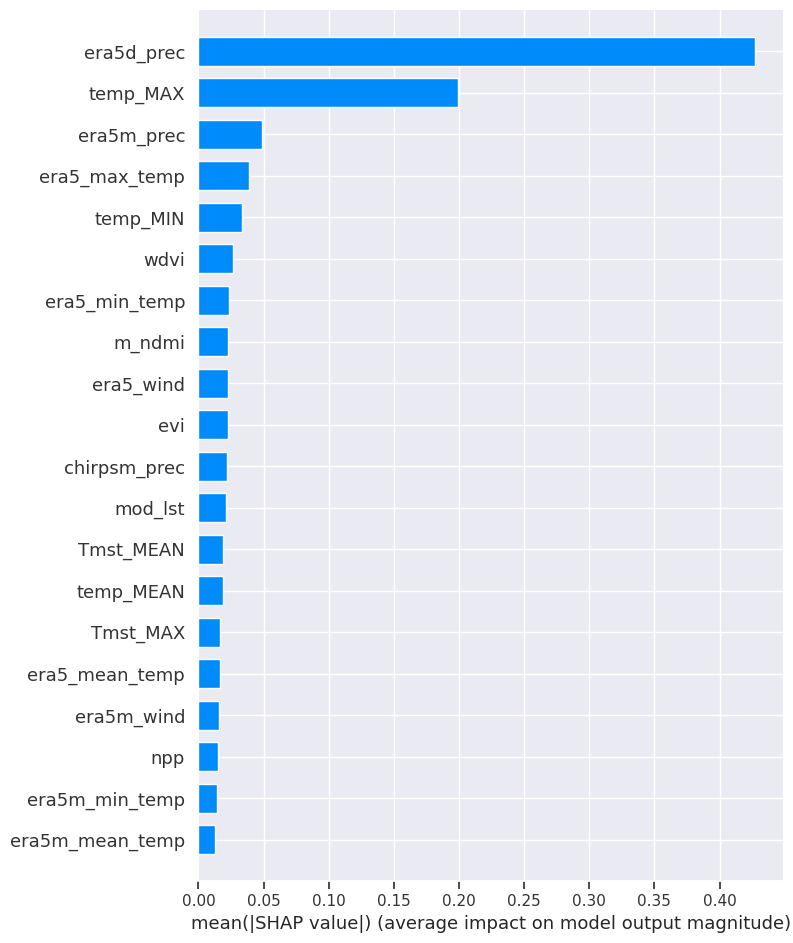

In [34]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
shap.summary_plot(shap_values, pred)

# 4.Pearson Correlation

## **4.1 Correlation Predictor Variables vs Yield**

### **4.1.1 Climate Predictor Variables vs Yield**

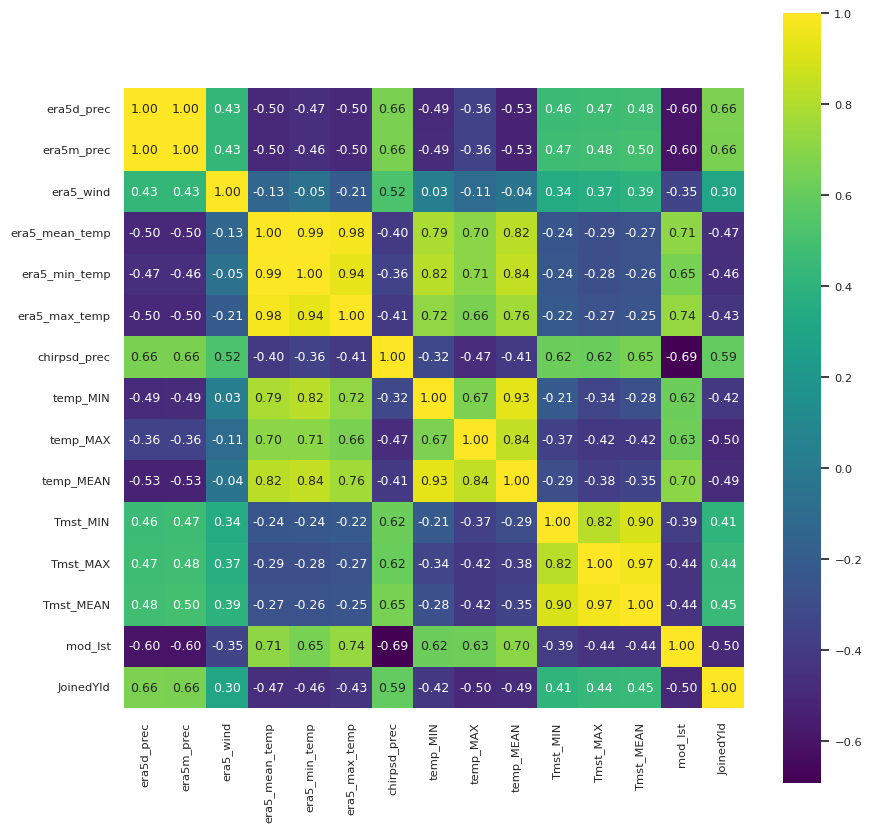

In [35]:
# clim_var = [ 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
#        'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
#        'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
#        'temp_MIN', 'temp_MAX', 'temp_MEAN', 'temp_STD', 'temp_SUM', 'Tmst_MIN',
#        'Tmst_MAX', 'Tmst_MEAN', 'Tmst_STD', 'Tmst_SUM','mod_lst', 'ggcp10','JoinedYld', 'Yield','Yield2','final_Yld']
clim_var = [ 'era5d_prec','era5m_prec', 'era5_wind','era5_mean_temp', 'era5_min_temp', 'era5_max_temp','chirpsd_prec',
            'temp_MIN', 'temp_MAX', 'temp_MEAN',  'Tmst_MIN','Tmst_MAX', 'Tmst_MEAN','mod_lst',
             'JoinedYld']

clim = pd.DataFrame(data, columns=clim_var)
fig = plt.figure(figsize=(10,10))

dataplot = sns.heatmap(clim.corr(),cmap="viridis", annot=True,fmt='.2f', annot_kws = {'size':9},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=True)
# sns.set(font_scale=0.8)

order = feature_importance.groupby('Features').mean().sort_values('Importance',ascending=False).index
# barplot = sns.barplot(feature_importance['Importance'],feature_importance['Features'],order=order,orient = 'h',palette=("Blues_r"),ax =ax2)
# ax2.barh()
# plt.xlabel("RF Importance")
plt.show()

**Review the Correlation over the years.,,,**

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


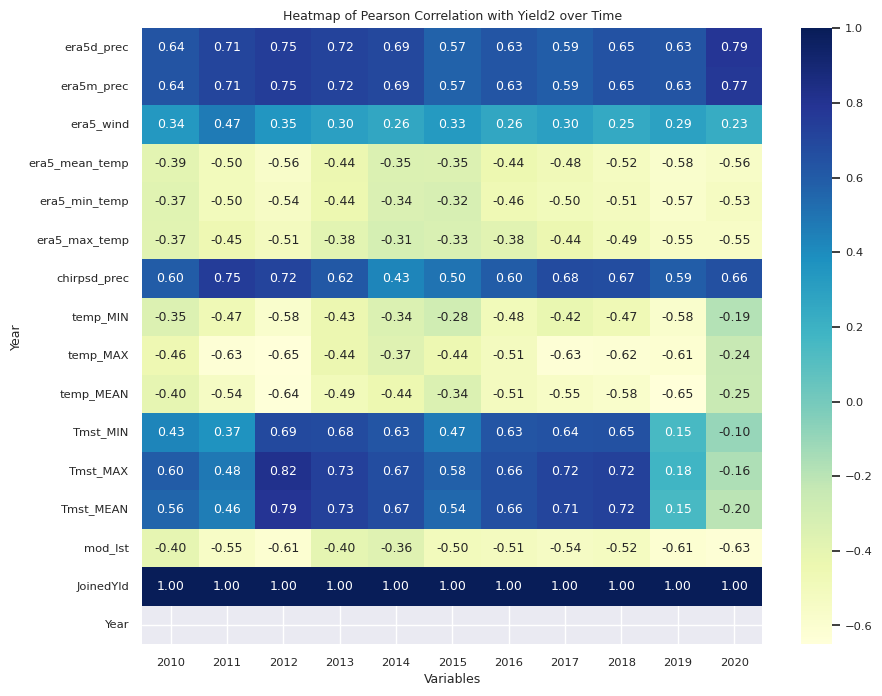

In [36]:
# Group data by year
clim_vars =  [ 'era5d_prec','era5m_prec', 'era5_wind','era5_mean_temp', 'era5_min_temp', 'era5_max_temp','chirpsd_prec',
            'temp_MIN', 'temp_MAX', 'temp_MEAN',  'Tmst_MIN','Tmst_MAX', 'Tmst_MEAN','mod_lst','JoinedYld','Year']
climy = pd.DataFrame(data, columns=clim_vars)
grouped = climy.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield2 over Time")
plt.show()

### **4.1.2 MODIS Predictor Variables vs Yield**

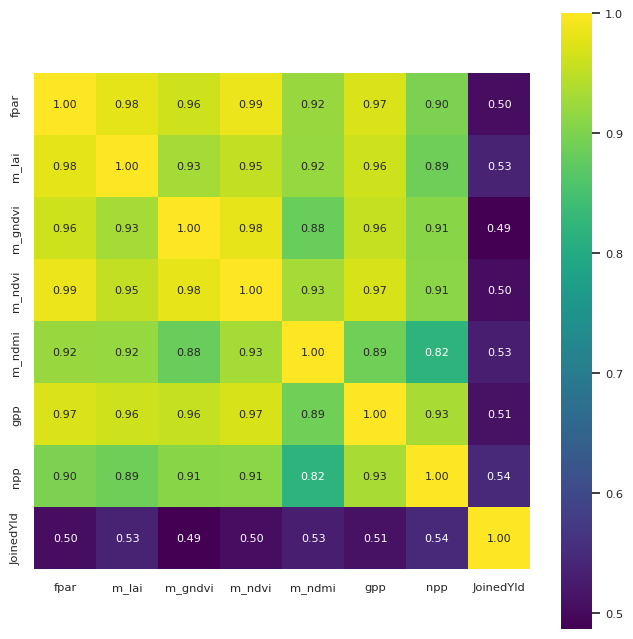

In [37]:
mod_var = ['fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp', 'npp','JoinedYld']
mod = pd.DataFrame(data, columns=mod_var)
fig = plt.figure(figsize=(8,8))

dataplot = sns.heatmap(mod.corr(),cmap="viridis", annot=True,fmt='.2f', annot_kws = {'size':8},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=True)
# sns.set(font_scale=0.8)

# order = feature_importance.groupby('Features').mean().sort_values('Importance',ascending=False).index
# barplot = sns.barplot(feature_importance['Importance'],feature_importance['Features'],order=order,orient = 'h',palette=("Blues_r"),ax =ax2)
# ax2.barh()
# plt.xlabel("RF Importance")
plt.show()

**Review the Correlation over the years.,,,**

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


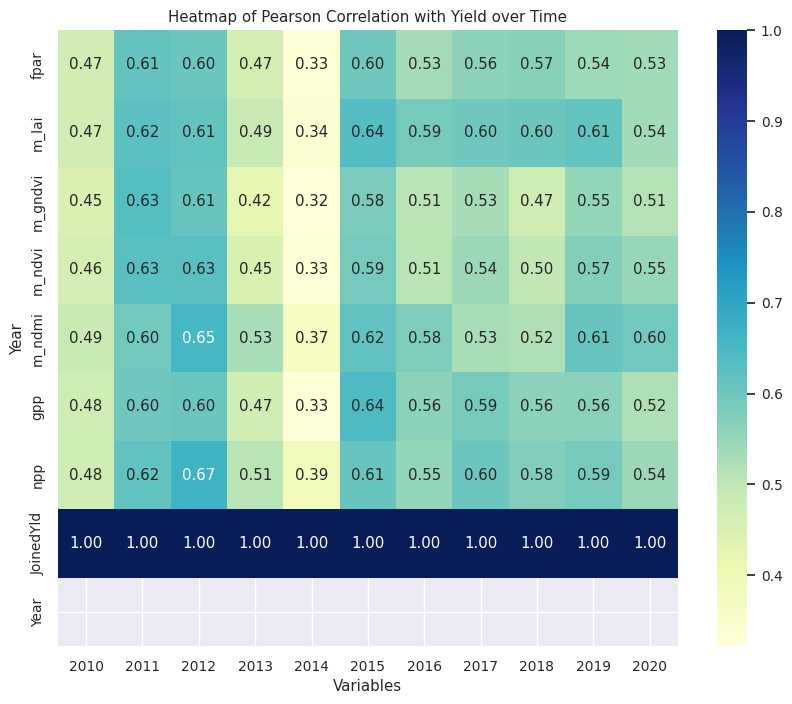

In [38]:
# Group data by year
mod_var_y = ['fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp','npp', 'JoinedYld','Year']
mod_y = pd.DataFrame(data, columns=mod_var_y)
grouped = mod_y.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)
sns.set(font_scale=0.9)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()

### **4.1.3 Landsat Indices Predictor Variables vs Yield**

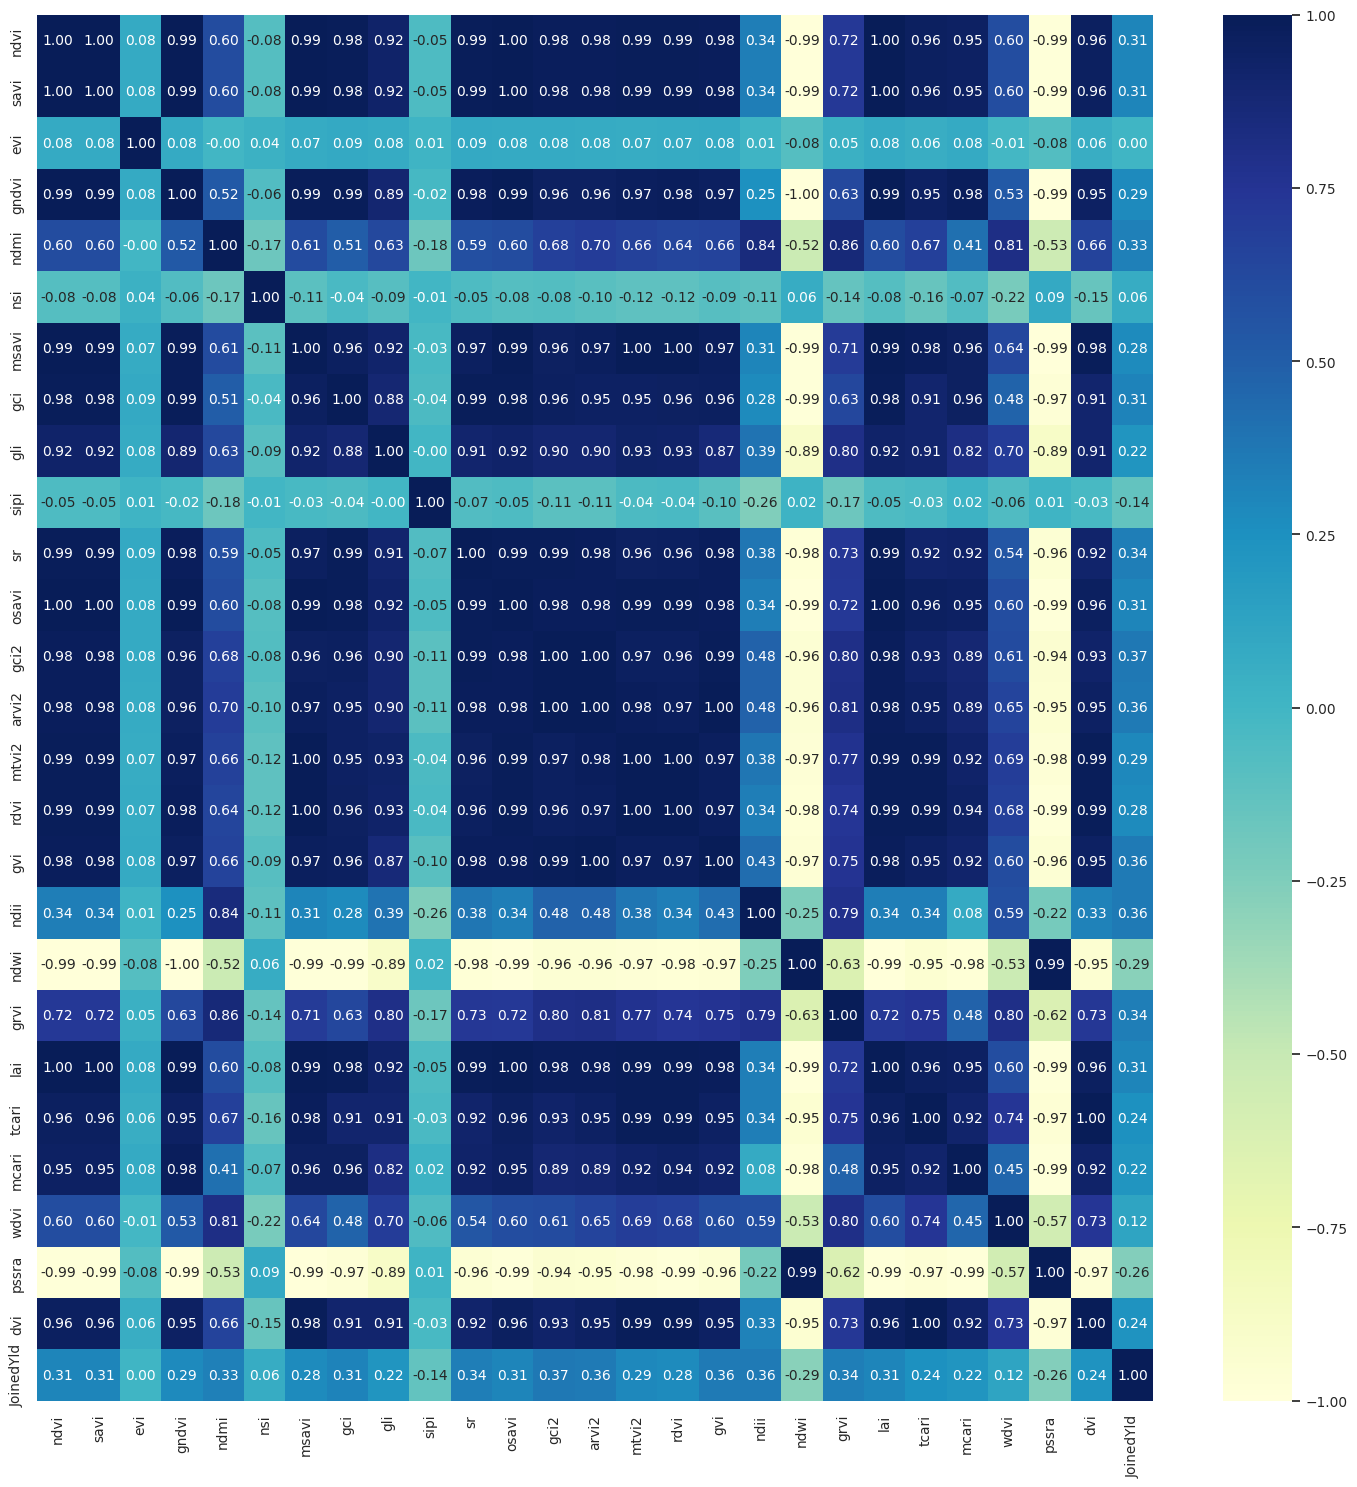

In [40]:
indx_var = ['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi','msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
            'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi','pssra', 'dvi', 'JoinedYld']
indx = pd.DataFrame(data, columns=indx_var)
fig = plt.figure(figsize=(18,18))

dataplot = sns.heatmap(indx.corr(),cmap="YlGnBu", annot=True,fmt='.2f', annot_kws = {'size':10},
                       cbar_kws = dict(use_gridspec=False,location="right"),square=False)
sns.set(font_scale=2)
dataplot.set(xlabel="", ylabel="")
# order = feature_importance.groupby('Feature').mean().sort_values('Importance',ascending=False).index
# barplot = sns.barplot(feature_importance['Importance'],feature_importance['Features'],order=order,orient = 'h',palette=("Blues_r"),ax =ax2)
# ax2.barh()
# plt.xlabel("RF Importance")
plt.show()

**Review the Correlation over the years.,,,**

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


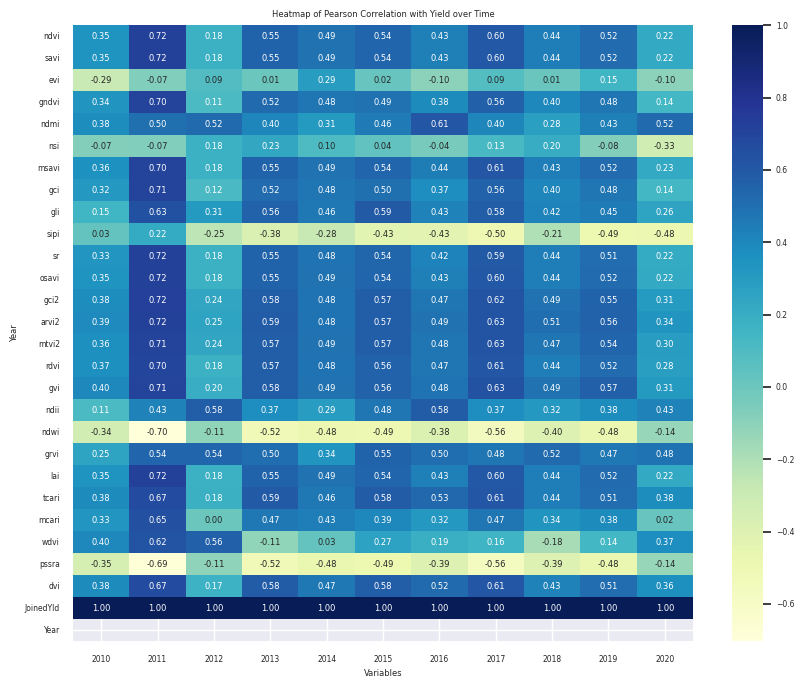

In [41]:
indx_var_y = ['ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'JoinedYld', 'Year']
indx_y = pd.DataFrame(data, columns=indx_var_y)
# Group data by year
grouped = indx_y.groupby('Year')

# Create an empty dictionary to store correlation values
correlation_data = {}

# Iterate through each year's data
for year, group_data in grouped:
    # Calculate the Pearson correlation with 'Yield2' for each column
    correlations = group_data.corrwith(group_data['JoinedYld'])

    # Store correlations for the current year
    correlation_data[year] = correlations

# Create a DataFrame from the correlation data
heatmap_data = pd.DataFrame(correlation_data)
sns.set(font_scale=0.5)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.xlabel("Variables")
plt.ylabel("Year")
plt.title("Heatmap of Pearson Correlation with Yield over Time")
plt.show()



```
TRAINING WITH SELECTED FEATURES
```
# **5. Random Forest Regressor**

In [43]:
new_data = pd.DataFrame(data=data)
new_data.columns
# 'sipi', 'gci', 'gli', 'ndmi','msavi', 'gndvi','Yield'
# 'evi', 'gci', 'gli', 'gndvi', 'msavi', 'ndmi', 'ndvi', 'nsi', 'savi','sipi'

Index(['key', 'COUNTY', 'Year', 'Yield', 'blue', 'green', 'red', 'nir',
       'swir1', 'swir2', 'ndvi', 'savi', 'evi', 'gndvi', 'ndmi', 'nsi',
       'msavi', 'gci', 'gli', 'sipi', 'sr', 'osavi', 'gci2', 'arvi2', 'mtvi2',
       'rdvi', 'gvi', 'ndii', 'ndwi', 'grvi', 'lai', 'tcari', 'mcari', 'wdvi',
       'pssra', 'dvi', 'era5d_prec', 'era5_wind', 'era5m_wind', 'era5m_prec',
       'era5_mean_temp', 'era5_min_temp', 'era5_max_temp', 'era5m_mean_temp',
       'era5m_min_temp', 'era5m_max_temp', 'chirpsd_prec', 'chirpsm_prec',
       'AREA', 'temp_MIN', 'temp_MAX', 'RANGE', 'temp_MEAN', 'temp_STD',
       'temp_SUM', 'fpar', 'm_lai', 'm_gndvi', 'm_ndvi', 'm_ndmi', 'gpp',
       'npp', 'Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN',
       'Tmst_STD', 'Tmst_SUM', 'Yield2', 'mod_lst', 'ggcp10', 'final_Yld',
       'JoinedYld'],
      dtype='object')

In [44]:
features= new_data

**Select the Selected features**

In [58]:
# TRAIN SPLIT
yld = new_data['JoinedYld']
pred = new_data[['era5d_prec', 'temp_MAX', 'era5m_prec','era5m_max_temp', 'temp_MIN',  'wdvi','era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec', 'mod_lst']]
# tamsat = new_data[['Tmst_AREA', 'Tmst_MIN', 'Tmst_MAX', 'Tmst_RANGE', 'Tmst_MEAN','Tmst_STD', 'Tmst_SUM']]
# tamsat.describe()

In [59]:
pred.columns

Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')

In [ ]:
# y_train.shape

In [60]:
# RF Regressor & Fit
# create a classifier and fit
n_trees = 200
clf = RandomForestRegressor(n_trees,random_state = 42)
clf.fit(pred,yld)

RandomForestRegressor(n_estimators=200, random_state=42)

In [61]:
feature_name=pred.columns
feature_name

Index(['era5d_prec', 'temp_MAX', 'era5m_prec', 'era5m_max_temp', 'temp_MIN',
       'wdvi', 'era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec',
       'mod_lst'],
      dtype='object')



```
# Leave One Year Out Cross Validation
```

# **6. Leave One Year Out Cross Validation**

In [62]:
logo = LeaveOneGroupOut()

In [63]:
group = data['Year']

In [64]:
logo.get_n_splits(groups=group)

11

**Validation Metrics:**
1. cross_val_score : Calculate score for each CV split.
2. cross_validate : Calculate one or more scores and timings for each CV split. To run cross-validation on multiple metrics and also to return
3. cross_val_predict : Get predictions from each split of cross-validation for diagnostic purposes.
4. make_scorer : Make a scorer from a performance metric or loss function

In [65]:
from sklearn.model_selection import cross_validate,cross_val_predict,permutation_test_score
from sklearn.metrics import make_scorer

In [66]:
scores = cross_val_score(clf,pred,yld,groups=group,scoring='neg_mean_squared_error',cv=logo,n_jobs=-1)


### **6.1. Cross Validation**
Run cross-validation on R2, MSE, RMSE, MAPE metrics and also to return train scores, fit times and score times


In [67]:
cross_validate_results = cross_validate(clf,pred,yld,groups=group,
                                        scoring=('r2', 'neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_percentage_error'),
                                        return_train_score=True,cv=logo,n_jobs=-1)

In [68]:
cross_validate_results.keys()


dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error', 'test_neg_mean_absolute_percentage_error', 'train_neg_mean_absolute_percentage_error'])

In [69]:
metrics = pd.DataFrame(cross_validate_results, columns = ['train_r2','test_r2',
                                                          'train_neg_mean_squared_error','test_neg_mean_squared_error',
                                                          'train_neg_root_mean_squared_error','test_neg_root_mean_squared_error',
                                                          'train_neg_mean_absolute_percentage_error','test_neg_mean_absolute_percentage_error'])
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
metrics['Year'] = years
metrics

,train_r2,test_r2,train_neg_mean_squared_error,test_neg_mean_squared_error,train_neg_root_mean_squared_error,test_neg_root_mean_squared_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_percentage_error,Year
0,0.958832,0.588039,-0.035615,-0.363622,-0.188720,-0.603010,-0.171320,-0.272383,2010
1,0.955196,0.760285,-0.039236,-0.201980,-0.198081,-0.449422,-0.168162,-0.515346,2011
2,0.956538,0.751382,-0.037506,-0.235521,-0.193664,-0.485305,-0.160597,-0.601333,2012
3,0.957116,0.714693,-0.037652,-0.234535,-0.194042,-0.484288,-0.168521,-0.340844,2013
4,0.958902,0.661344,-0.035983,-0.281541,-0.189693,-0.530604,-0.166027,-0.347625,2014
5,0.960305,0.606117,-0.035760,-0.233841,-0.189104,-0.483571,-0.163347,-0.468455,2015
6,0.955821,0.729355,-0.038240,-0.243840,-0.195551,-0.493801,-0.157732,-0.801707,2016
7,0.955708,0.774767,-0.039339,-0.161061,-0.198340,-0.401323,-0.172793,-0.314824,2017
8,0.956693,0.710842,-0.037467,-0.274856,-0.193565,-0.524268,-0.173470,-0.339737,2018
9,0.957012,0.735604,-0.038020,-0.200454,-0.194987,-0.447721,-0.166111,-0.399765,2019


#### **6.1.1 Plot Train and Test Validation Metrics (R2, RMSE, MSE, MAPE)**

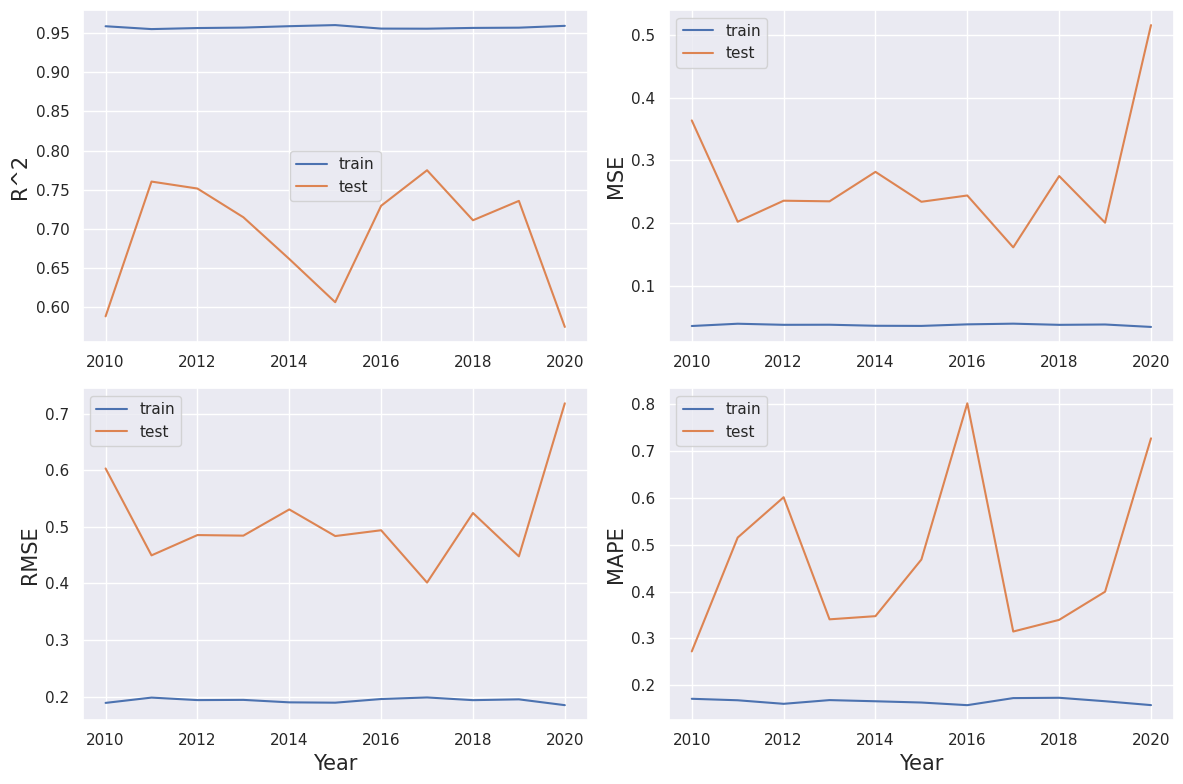

In [76]:
fig = plt.figure()
sns.set(font_scale=1)
ax1 = plt.subplot(2,2,1)

plt.plot(metrics['Year'],metrics['train_r2'],label='train')
plt.plot(metrics['Year'],metrics['test_r2'],label='test')
# ax1.title.set_text('R^2')
ax1.legend()
ax1.set_ylabel('R^2', fontsize=15)
# ax1.set_xlabel('Year', fontsize=15)

ax2 = plt.subplot(2,2,2)
plt.plot(metrics['Year'],(metrics['train_neg_mean_squared_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_mean_squared_error']*-1),label='test')
# ax2.title.set_text('MSE')
ax2.legend()
ax2.set_ylabel('MSE', fontsize=15)
# ax2.set_xlabel('Year', fontsize=15)

ax3 = plt.subplot(2,2,3)
plt.plot(metrics['Year'],(metrics['train_neg_root_mean_squared_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_root_mean_squared_error']*-1),label='test')
# ax3.title.set_text('RMSE')
ax3.set_ylabel('RMSE', fontsize=15)
ax3.set_xlabel('Year', fontsize=15)
ax3.legend()

ax4 = plt.subplot(2,2,4)
plt.plot(metrics['Year'],(metrics['train_neg_mean_absolute_percentage_error']*-1),label='train')
plt.plot(metrics['Year'],(metrics['test_neg_mean_absolute_percentage_error']*-1),label='test')
# ax2.title.set_text('MSE')
ax4.legend()
ax4.set_ylabel('MAPE', fontsize=15)
ax4.set_xlabel('Year', fontsize=15)

# Labels to use in the legend for each line
labels = ["Train", "Test"]

fig.tight_layout()
# fig.legend([ax3, ax3], labels=labels,loc="upper right")


### **6.2 Make predictions based on the new classifier**

In [72]:
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.metrics import r2_score

In [70]:
# Get predictions from each split of cross-validation for diagnostic purposes
cross_val_prediction = cross_val_predict(clf,pred,yld,groups=group,cv=logo,n_jobs=-1,)

In [ ]:
# cross_val_prediction.size


461

In [71]:
# Evaluate the significance of a cross-validated score with permutations.
#score,permutation_test_scores,pvalue = permutation_test_score(clf,pred,yld,groups=group,cv=logo,n_jobs=-1)

KeyboardInterrupt: 

Join the predictions with the data

In [74]:
data['predictions'] = cross_val_prediction
data.describe()

<ipython-input-74-94bd0a306e79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predictions'] = cross_val_prediction


,Year,Yield,blue,green,red,nir,swir1,swir2,ndvi,savi,...,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld,predictions
count,461.000000,378.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,461.000000,...,461.000000,461.000000,461.000000,461.000000,377.000000,461.000000,461.000000,377.000000,461.000000,461.000000
mean,2014.989154,1.565389,15413.454259,16035.975727,16347.604134,21227.513130,18042.259340,14523.145163,0.152170,0.228252,...,83.067897,100.195398,19.315664,10289.432996,1.571220,15053.640804,2.121945,1.536283,1.558705,1.567932
std,3.160540,0.935836,5396.852876,4722.485294,5078.652003,2472.150062,2630.079343,1723.876089,0.093239,0.139857,...,69.935337,86.706050,15.901291,16675.709297,0.937679,200.463762,1.175216,0.932666,0.935326,0.763054
min,2010.000000,0.073561,9143.756000,10170.156960,10070.378840,15201.186490,14264.674560,11113.324250,-0.125322,-0.187981,...,0.000000,0.000000,0.000000,0.000000,0.070000,14668.905120,0.015409,0.071642,0.071642,0.321923
25%,2012.000000,0.897919,11440.506530,12569.025170,12726.295270,19374.466470,16126.576420,13175.964870,0.104337,0.156503,...,33.299999,11.487143,7.569266,758.600007,0.900000,14921.335210,1.364666,0.886684,0.901980,0.993742
50%,2015.000000,1.368918,14064.890690,14811.063700,14930.986940,20783.808090,17314.475710,14191.067040,0.168225,0.252335,...,66.599998,87.055883,15.909070,5918.016678,1.380000,15028.829250,2.199110,1.311205,1.337808,1.425716
75%,2018.000000,2.156738,17864.987290,18125.811950,18580.042740,22883.315890,19505.411060,15853.188390,0.219557,0.329329,...,121.200005,158.198156,26.893221,14614.299990,2.110000,15150.634030,2.957867,2.014130,2.078988,1.925086
max,2020.000000,5.090926,40761.130780,39770.558290,40505.574260,32026.710420,32362.643070,18865.725980,0.310899,0.466341,...,443.000000,389.870093,93.047153,264718.399900,5.090000,15878.890780,5.522266,5.224867,5.224867,4.207367


#### **6.2.1 Predicted vs. actual Variables plot**

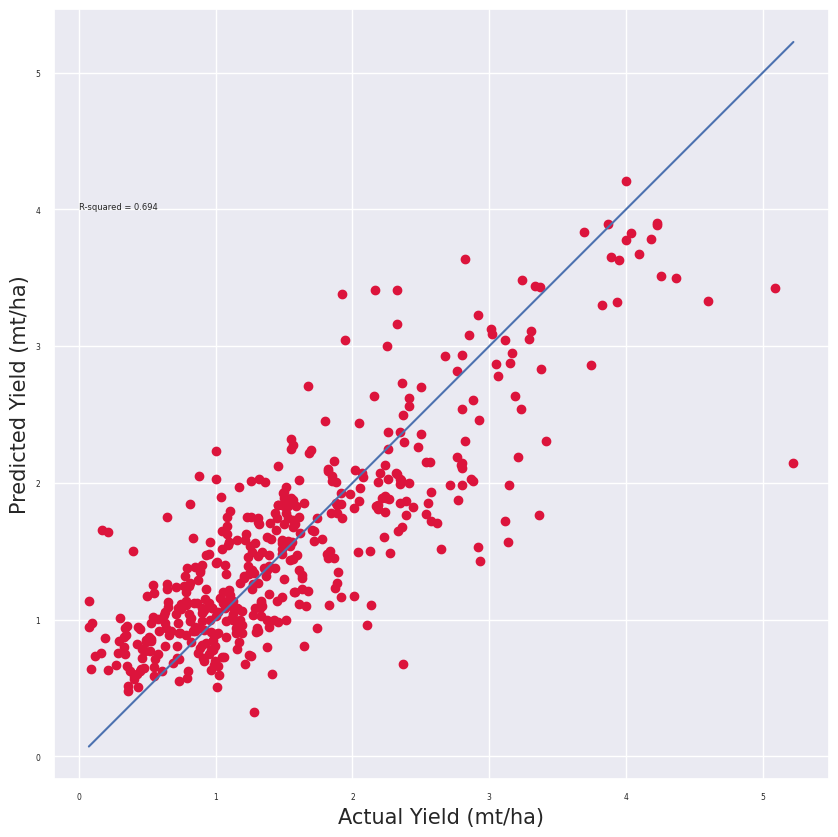

In [75]:
plt.figure(figsize=(10,10))
plt.scatter(data['JoinedYld'], data['predictions'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')
y_test = data['JoinedYld']
y_predicted = data['predictions']
p1 = max(max(data['predictions']), max(data['JoinedYld']))
p2 = min(min(data['predictions']), min(data['JoinedYld']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 4))
plt.show()

# **7. Export and Save the Classifier**

In [84]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(clf,feature_name,2,"REGRESSION")

In [ ]:
# number of trees we converted should equal the number of trees we defined for the model
# len(trees) == n_trees

In [85]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

In [ ]:
# ee_classifier.getInfo()

In [ ]:
# joblib.dump(clf, "./random_forest.joblib")

In [ ]:
# ee_serialized = ee_classifier.serialize()

In [90]:
user_id = geemap.ee_user_id()
user_id

# specify asset id where to save trees
# be sure to change  to your ee user name
asset_id = user_id + "/random_forest_"
asset_id


'projects/ee-maizeyield/assets/LR_18/random_forest_'

In [91]:
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

# this will kick off an export task, so wait a few minutes before moving on

In [ ]:
# # read the exported tree feature collection
rf_fc = ee.FeatureCollection(asset_id)

# # convert it to a classifier, very similar to the `ml.trees_to_classifier` function
another_classifier = ml.fc_to_classifier(rf_fc)

# # classify the image again but with the classifier from the persisted trees
classified = image.select(feature_names).classify(another_classifier)

In [ ]:
# import os

# out_csv = os.path.expanduser("/content/drive/MyDrive/trees.csv")

In [ ]:
# ml.trees_to_csv(trees, out_csv)

In [ ]:
# another_classifier = ml.csv_to_classifier(out_csv)

In [ ]:
# classified = image.select(feature_names).classify(another_classifier)

In [ ]:
# task = ee.batch.Export.table.toAsset(**{
#     'collection'=encodeFeatureCollection(decisionTrees),
#     'description'='export_classifier',
#     'assetId'='users/Prod/ee_classifier',
# })
# task.start()

# **8. TESTING WITH 2021-2022 DATA**

Extract 2021 and 2022 data

In [95]:
test21_22 = df[df['Year'].between(2021, 2022)]
test21_22

,key,COUNTY,Year,Yield,blue,green,red,nir,swir1,swir2,...,Tmst_MAX,Tmst_RANGE,Tmst_MEAN,Tmst_STD,Tmst_SUM,Yield2,mod_lst,ggcp10,final_Yld,JoinedYld
461,2021_BARINGO,BARINGO,2021,NaN,11460.898160,12608.92418,12767.00062,18531.36454,16179.79557,13680.72272,...,247.800003,154.200005,160.355932,41.961498,28382.999920,1.70,15095.44521,NaN,1.704726,1.704726
462,2021_BOMET,BOMET,2021,NaN,9326.657492,10715.91775,10443.58105,19385.59656,15527.53833,12343.67468,...,210.199997,107.500000,154.028071,24.544730,8779.600021,1.45,14928.34416,NaN,1.704726,1.704726
463,2021_BUNGOMA,BUNGOMA,2021,NaN,12602.566820,13714.83854,13540.80900,21093.64886,16551.06540,13644.29079,...,209.600006,76.700012,166.999999,17.446569,22878.999890,2.89,14967.61093,NaN,1.704726,1.704726
464,2021_BUSIA,BUSIA,2021,NaN,10622.750650,12029.86649,11925.33456,19882.61603,16348.67698,13358.70258,...,188.100006,57.700012,160.351853,14.128014,12988.500080,1.24,15078.83896,NaN,1.243064,1.243064
465,2021_ELGEYO-MARAKWET,ELGEYO-MARAKWET,2021,NaN,14092.756490,15062.52645,15072.34865,21431.18750,17253.12189,14392.27486,...,232.899994,129.399994,168.205455,33.262856,9251.300011,2.74,14847.02643,NaN,2.743357,2.743357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2022_TRANS NZOIA,TRANS NZOIA,2022,NaN,13280.046530,14416.41360,14387.53534,21319.92801,16868.91258,14168.32388,...,158.500000,77.099998,118.168142,16.064765,13353.000050,NaN,14960.55193,NaN,3.573576,3.573576
539,2022_TURKANA,TURKANA,2022,NaN,11081.265230,12701.43966,13370.20804,19215.70020,16788.13028,14694.39021,...,0.600000,0.000000,0.600000,0.000000,0.600000,NaN,15787.10061,NaN,0.132482,0.132482
540,2022_UASIN GISHU,UASIN GISHU,2022,NaN,15924.236490,16793.24959,16900.12788,22514.50984,18307.82148,15405.13307,...,155.100006,79.300003,104.667683,17.023466,17165.499950,NaN,14891.12617,NaN,3.500000,3.500000
541,2022_VIHIGA,VIHIGA,2022,NaN,10899.808670,12243.34086,12113.23125,20331.52333,15659.46462,12856.96251,...,220.199997,53.500000,189.724137,12.211233,5501.999985,NaN,14929.61504,NaN,0.969130,0.969130


In [96]:
testdf = test21_22[['era5d_prec', 'temp_MAX', 'era5m_prec','era5m_max_temp', 'temp_MIN',  'wdvi','era5_min_temp', 'm_ndmi', 'era5_wind', 'evi', 'chirpsm_prec', 'mod_lst']]
testdf

,era5d_prec,temp_MAX,era5m_prec,era5m_max_temp,temp_MIN,wdvi,era5_min_temp,m_ndmi,era5_wind,evi,chirpsm_prec,mod_lst
461,0.007518,31.938599,0.230155,301.254753,20.238519,12147.86424,288.656887,0.087983,-0.299053,1.784001,22.909437,15095.44521
462,0.004619,25.965830,0.142757,298.805258,21.916509,14163.80606,286.802469,0.161588,-1.188601,1.877671,23.732274,14928.34416
463,0.011963,29.982564,0.368024,298.162482,22.469358,14323.24436,287.453198,0.186639,-0.261648,2.557420,33.603505,14967.61093
464,0.006809,30.161824,0.210320,302.138288,28.635179,13919.94874,291.236583,0.141153,-0.107021,1.749971,33.252457,15078.83896
465,0.020667,30.615132,0.631211,297.521671,19.262981,13895.01320,286.179631,0.156446,-0.240836,3.455338,26.392680,14847.02643
...,...,...,...,...,...,...,...,...,...,...,...,...
538,0.003577,35.909781,0.105212,301.818151,28.409985,14126.16034,290.746945,0.199905,-0.690943,3.544773,4.186121,14960.55193
539,0.010982,26.444695,0.342975,297.896131,21.775780,12530.59622,286.951076,-0.021080,-0.598598,1.003145,0.652969,15787.10061
540,0.003721,34.401841,0.112294,307.303309,34.401841,14064.44591,295.115950,0.155621,-0.584549,2.852756,3.949027,14891.12617
541,0.010243,26.659979,0.321295,298.012243,20.808950,14274.90774,286.445862,0.231280,-0.231377,1.911246,6.286040,14929.61504


In [97]:
predictions = clf.predict(testdf)
predictions

array([1.49598933, 1.73422179, 1.62960352, 1.56252191, 3.12960164,
       1.09308893, 0.87910793, 0.87029392, 0.93972421, 2.55117035,
       2.7340313 , 1.16129061, 0.76502393, 1.18443073, 1.75653023,
       1.41778584, 0.55585783, 0.70762171, 1.37676096, 1.47205953,
       0.75763647, 0.63946253, 0.5934216 , 1.10153468, 1.31634255,
       0.93867906, 2.10483572, 2.51580555, 2.05237321, 1.72043347,
       1.51945797, 0.84831679, 1.17623913, 1.36254348, 0.84697998,
       0.87333443, 1.48084244, 3.38519911, 1.33470047, 3.32551381,
       1.51706668, 1.45781368, 1.55106066, 1.73087734, 1.41765739,
       2.78386718, 1.22923063, 1.16457121, 0.91954391, 1.19271636,
       1.69927402, 2.52404601, 1.08214574, 0.8293267 , 1.22311267,
       1.52150413, 1.43005015, 0.60606019, 0.77231186, 1.50500469,
       1.47255399, 0.76718591, 0.81818403, 0.64042742, 1.03114331,
       1.36072816, 1.00774621, 1.71790382, 1.85707537, 1.87081787,
       1.44524257, 1.54228733, 0.9203161 , 1.27800271, 1.43213

In [ ]:
test21_22['predictions'] = predictions
test21_22.describe()

In [104]:
yieldtest = test21_22['JoinedYld']


In [106]:
r2_score(yieldtest,predictions )
print('R-squared:', round(100 * (r2_score(yieldtest,predictions )), 2), '%.')

R-squared: 4.7 %.


# **9.Testing  Field dataaset**

In [79]:
from IPython.utils import frame
from pandas.core.indexes.base import PrettyDict
#Predict on 2021 data
# 1. Get Image
# 2. Predict using classifier
# 3. Extract the values of Image on PULA data add to the pula data frame
# 4. Validate the 2 values

In [80]:
# //Define Year of Study
start = ee.Date("2022-04-01")
end = ee.Date("2022-09-15")
scale = 10000;
# prod2021 = ee.FeatureCollection("users/Prod/maize_2021")
prod2021 = ee.FeatureCollection("users/Prod/tn_maize_2022")
AOI = prod2021.geometry()
# L8 Image Collection of Interest
imgcol = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")


In [ ]:
# Setup
Map = geemap.Map()
Map.centerObject(AOI, 12)
Map.addLayer(AOI,{},'AOI')
Map

TimeoutException: Requesting secret GOOGLE_MAPS_API_KEY timed out. Secrets can only be fetched when running from the Colab UI.

In [ ]:

## Load the L8 Collection and Processs & Get Indices
from prepareimg import l8prep,addIndices
l8 = l8prep(start,end,imgcol,AOI)
test_VIS = addIndices(l8,AOI)

In [ ]:
test_VIS.getInfo()

In [ ]:
# SELECT Indices
test_img = test_VIS.select('evi', 'gci', 'gli', 'gndvi', 'msavi', 'ndmi', 'ndvi', 'nsi','savi', 'sipi')


In [ ]:
# Classify the Test Image
classified = test_img.classify(ee_classifier)


In [ ]:
# Reduce Regions to The test Areas
test_reg = classified.reduceRegions(**{
    'collection':prod2021,
    'reducer': ee.Reducer.mean(),
    'scale': 30

})

In [ ]:
# Map.addLayer(classified,{'palette':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
#   '74A901', '66A000', '529400', '3E8601', '207401', '056201',
#   '004C00', '023B01', '012E01', '011D01', '011301'],'min':0.07356099784374237,'max':4.364237308502197},'CLASIFIED')

In [ ]:
Map.addLayer(test_reg)

In [ ]:
# geemap.ee_export_vector(test_reg, 'test21.csv')


In [ ]:
# geemap.ee_export_image(test_img,'test_img.tif')


In [ ]:
Map

In [ ]:
test21 = pd.read_csv('/content/test21.csv')
test21

In [ ]:
#  Calculate the absolute errors
errors = abs(test21['mean'] - test21['Yield(Mt/h'])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
#view RMSE
print('RMSE:', round(sqrt(mean(absolute(scores))), 2))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test21['Yield(Mt/h'])
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print('MAPE:', round(np.mean(mape), 2), '%.')


In [ ]:
test21[test21.isna().any(axis=1)]

In [ ]:
test21 = test21[test21['mean'].notna()]

In [ ]:
y_test = test21['Yield(Mt/h']
y_predicted = test21['mean']
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Yield (mt/ha)', fontsize=15)
plt.ylabel('Predicted Yield (mt/ha)', fontsize=15)
plt.axis('equal')
plt.annotate("R-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 9))
plt.show()

In [ ]:
test21=test21[test21['mean'] > 0]

y_true = test21['Yield(Mt/h']
y_pred = test21['mean']
mape = mean_absolute_percentage_error(y_true, y_pred)
mse =  mean_squared_error(y_true, y_pred)
rmse =  mean_squared_error(y_true, y_pred,squared=False)
r2 =  r2_score(y_true, y_pred)
test_dict = {'index':[0],'MAPE': mape,'MSE':mse,'RMSE':rmse,'r2':r2}
test_metrics = pd.DataFrame(data=test_dict)
test_metrics